# 1.The reason why the exact solution of heat equation does not hold for the energy estimate.
The energy estimate
$$E(t)\le e^{-\gamma t}E(0)+\frac1\gamma\int_0^t e^{\gamma(s-t)}F(s)\,ds$$
is derived under the assumptions that the solution satisfies homogeneous Dirichlet boundary conditions (so that boundary terms vanish) and that a Poincaré inequality holds, which gives a coercivity estimate
$$-\nu\int u_{xx}u\le -\gamma E(t)$$.
For the exact solution of the heat equation with general (e.g. Neumann or non-homogeneous) boundary conditions, these assumptions fail: the boundary terms need not vanish and the Poincaré inequality may not hold. Therefore the differential inequality for $E(t)$ (and hence the exponential energy estimate) does not necessarily hold for the exact solution in this setting.

#2.
Consider the diffusion equation:
$$
u_t=u_{xx}, 0 \le x \le 1,\ t\ge0
$$
with initial and boundary conditions
$$
u(x,0)=\sin(\frac{1}{2}\pi x)+\frac{1}{2}\sin(2\pi x),\ \ u(0,t)=0,\ u(1,t)=e^{\frac{-\pi^2 t}{4}}
$$
Solve the problem using Forward Euler finite difference method with $\mu=0.5$ and $\mu=0.509$

The exact solution of this problem is given as
$$
u(x,t)
= \sin\!\Big(\frac{\pi}{2}x\Big)e^{-\frac{\pi^2}{4}t}
+ \frac12\sin(2\pi x)e^{-4\pi^2 t}.
$$

In [10]:
import numpy as np
def u_exact(x, t):
    pi = np.pi
    return (np.sin(0.5*pi*x) * np.exp(- (pi**2/4) * t)
            + 0.5 * np.sin(2*pi*x) * np.exp(- 4*pi**2 * t))

def forward_euler_heat(mu, M=40, T=1):
    h = 1.0 / M
    k = mu * h**2
    N = int(T / k)
    T_actual = N * k

    x = np.linspace(0.0, 1.0, M+1)
    pi = np.pi
    u = np.sin(0.5*pi*x) + 0.5*np.sin(2*pi*x)
    for n in range(N):
        t_n = n * k
        u[0]  = 0.0
        u[-1] = np.exp(- (pi**2/4) * t_n)
        u_new = u.copy()
        for j in range(1, M):
            u_new[j] = u[j] + mu * (u[j+1] - 2*u[j] + u[j-1])

        u = u_new
    u[0]  = 0.0
    u[-1] = np.exp(- (pi**2/4) * T_actual)
    u_ex = u_exact(x, T_actual)
    err = u - u_ex

    err_max = np.max(np.abs(err))
    err_L2  = np.sqrt(h * np.sum(err**2))

    return x, u, T_actual, err_max, err_L2
for mu in [0.5, 0.509]:
    print(f"\n===== mu = {mu} =====")
    x, u_num, T_used, emax, eL2 = forward_euler_heat(mu, M=40, T=0.5)
    print(f"Final time used: T = {T_used:.5f}")
    print(f"max error  ≈ {emax:.6e}")
    print(f"L2  error  ≈ {eL2:.6e}")


===== mu = 0.5 =====
Final time used: T = 0.49969
max error  ≈ 2.049468e-05
L2  error  ≈ 1.466822e-05

===== mu = 0.509 =====
Final time used: T = 0.49977
max error  ≈ 1.150853e+12
L2  error  ≈ 8.137760e+11


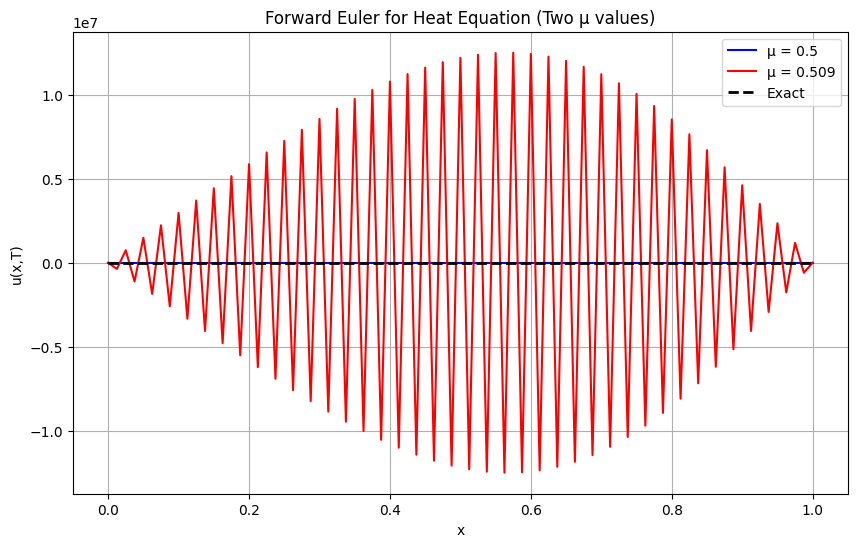

In [11]:
import matplotlib.pyplot as plt
mus = [0.5, 0.509]
colors = ['blue', 'red']

plt.figure(figsize=(10, 6))

for mu, color in zip(mus, colors):
    x, u_num, T = forward_euler(mu)
    plt.plot(x, u_num, label=f"μ = {mu}", color=color)
x_exact = np.linspace(0, 1, 400)
u_ex = u_exact(x_exact, T)
plt.plot(x_exact, u_ex, 'k--', linewidth=2, label='Exact')

plt.xlabel("x")
plt.ylabel("u(x,T)")
plt.title("Forward Euler for Heat Equation (Two μ values)")
plt.legend()
plt.grid(True)
plt.show()

# 3
Consider the diffusion equation:
$$u_t=u_{xx}$$
with initial and boundary conditions
$$u(x,0)=sin(2\pi x )e^x,u(0,t)=u(1,t)=0$$
With the aid of Fast Since transform, solve the problem using
(a) finite difference method and (b) method of line approach to
. Find the order of convergence.

# (a) Finite difference method
Since we can't find the exact solution, so the error here is defined as
$$
\lvert u_h-u_{ref}\lvert,
$$
where $u_h$ is the numerical solution of finite differnec method, and $u_{ref}$ is the solution of same numerical method with node sufficient large.

In [20]:
import numpy as np
from scipy.fft import dst, idst
pi = np.pi

def u_init(x):
    return np.sin(2*pi*x) * np.exp(x)

def dst1(u):
    return dst(u, type=1)

def idst1(uhat):
    n = uhat.size
    return idst(uhat, type=1) / (2*(n+1))

def laplace_eigenvalues(M, h):
    k = np.arange(1, M+1)
    return -4.0/(h**2) * np.sin(0.5*pi*k*h)**2

# ---------------------------
# (a) Backward Euler + FST
# ---------------------------
def solve_BE_FST(M, T, dt):
    h = 1.0 / (M+1)
    x = (np.arange(1, M+1))*h

    u = u_init(x)

    lam = laplace_eigenvalues(M, h)

    N = int(np.round(T/dt))
    dt = T / N

    for _ in range(N):
        uhat = dst1(u)
        uhat_new = uhat / (1.0 - dt * lam)
        u = idst1(uhat_new)

    return x, u

# ---------------------------
# Error & convergence study
# ---------------------------
def interpolate_to_grid(x_coarse, x_fine, u_fine):
    return np.interp(x_coarse, x_fine, u_fine)

def convergence_study():
    T = 0.1
    Ms = [63, 127, 255, 511]
    dt_factor = 0.4

    x_ref, u_ref = reference_solution(T, M_ref=4095)

    print("=== (a) Backward Euler + FST ===")
    prev_err = None
    for M in Ms:
        h = 1.0/(M+1)
        dt = dt_factor * h**2
        x, u = solve_BE_FST(M, T, dt)

        u_ref_on_x = interpolate_to_grid(x, x_ref, u_ref)
        err = np.sqrt(h * np.sum((u - u_ref_on_x)**2))

        if prev_err is None:
            print(f"M={M:4d}, h={h:.4e}, L2-error={err:.4e}")
        else:
            rate = prev_err/err
            print(f"M={M:4d}, h={h:.4e}, L2-error={err:.4e}, ratio≈{rate:.3f}")
        prev_err = err
convergence_study()

=== (a) Backward Euler + FST ===
M=  63, h=1.5625e-02, L2-error=1.0083e-05
M= 127, h=7.8125e-03, L2-error=1.0083e-05, ratio≈1.000
M= 255, h=3.9062e-03, L2-error=1.0083e-05, ratio≈1.000
M= 511, h=1.9531e-03, L2-error=1.0083e-05, ratio≈1.000


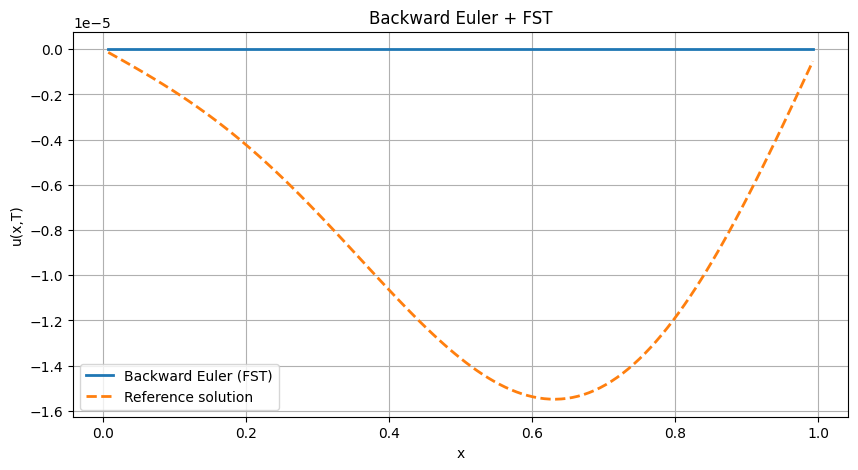

In [25]:
import matplotlib.pyplot as plt
from scipy.fft import dst, idst

pi = np.pi

T = 0.1
M_ref = 4095
x_ref, u_ref = reference_solution(T, M_ref)

M = 127
dt = 0.4 * (1.0/(M+1))**2

x_BE, u_BE = solve_BE_FST(M, T, dt)
u_ref_on_BE = np.interp(x_BE, x_ref, u_ref)

plt.figure(figsize=(10,5))
plt.plot(x_BE, u_BE, label="Backward Euler (FST)", linewidth=2)
plt.plot(x_BE, u_ref_on_BE, '--', label="Reference solution", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x,T)")
plt.title("Backward Euler + FST")
plt.grid(True)
plt.legend()
plt.show()


# (b) Method of Lines

In [16]:
# ---------------------------
# (b) Method of Lines + exact in time using FST
# ---------------------------
def solve_MOL_FST(M, T):
    h = 1.0 / (M+1)
    x = (np.arange(1, M+1))*h

    u0 = u_init(x)
    lam = laplace_eigenvalues(M, h)

    uhat0 = dst1(u0)

    uhatT = uhat0 * np.exp(lam * T)

    uT = idst1(uhatT)
    return x, uT
# ---------------------------
# Reference solution (very fine MOL)
# ---------------------------
def reference_solution(T, M_ref=2047):
    x_ref, u_ref = solve_MOL_FST(M_ref, T)
    return x_ref, u_ref
def convergence_study_2():
    T = 0.1
    Ms = [63, 127, 255, 511]
    dt_factor = 0.4

    x_ref, u_ref = reference_solution(T, M_ref=4095)

    print("\n=== (b) MOL + exact in time (FST) ===")
    prev_err = None
    for M in Ms:
        h = 1.0/(M+1)
        x, u = solve_MOL_FST(M, T)

        u_ref_on_x = interpolate_to_grid(x, x_ref, u_ref)
        err = np.sqrt(h * np.sum((u - u_ref_on_x)**2))

        if prev_err is None:
            print(f"M={M:4d}, h={h:.4e}, L2-error={err:.4e}")
        else:
            rate = prev_err/err
            print(f"M={M:4d}, h={h:.4e}, L2-error={err:.4e}, ratio≈{rate:.3f}")
        prev_err = err

convergence_study_2()


=== (b) MOL + exact in time (FST) ===
M=  63, h=1.5625e-02, L2-error=6.3549e-04
M= 127, h=7.8125e-03, L2-error=3.1260e-04, ratio≈2.033
M= 255, h=3.9062e-03, L2-error=1.5125e-04, ratio≈2.067
M= 511, h=1.9531e-03, L2-error=7.0580e-05, ratio≈2.143


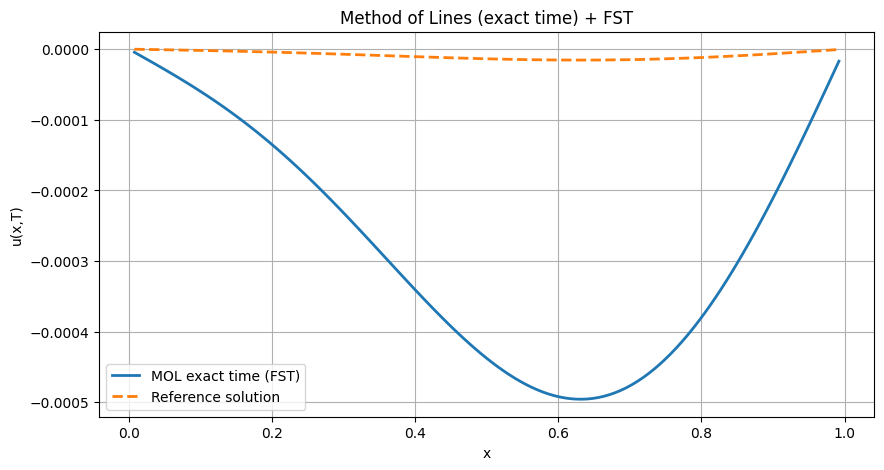

In [24]:
x_MOL, u_MOL = solve_MOL_FST(M, T)
u_ref_on_MOL = np.interp(x_MOL, x_ref, u_ref)

plt.figure(figsize=(10,5))
plt.plot(x_MOL, u_MOL, label="MOL exact time (FST)", linewidth=2)
plt.plot(x_MOL, u_ref_on_MOL, '--', label="Reference solution", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x,T)")
plt.title("Method of Lines (exact time) + FST")
plt.grid(True)
plt.legend()
plt.show()